Objectif R2 max

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set_style('whitegrid')

In [11]:
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

cf = cf[["FR"]]
ta = ta.loc[:, ta.columns.str.startswith("FR")]
tp = tp.loc[:, tp.columns.str.startswith("FR")]

In [12]:
data = pd.concat([ta.mean(axis=1).rename("TA"),
                  tp.mean(axis=1).rename("TP"),
                  cf["FR"].rename("CF")], axis=1)

In [13]:
# Features & Target
X = data.drop(columns="CF")
y = data["CF"]

#ajout d'une feunêtre
X_days_TP = X["TP"].rolling(window=7, min_periods=1).sum()
X_days_TA = X["TA"].rolling(window=60, min_periods=1).mean()
X_days_TP = X_days_TP.reset_index(drop=True)
X_days_TA = X_days_TA.reset_index(drop=True)

#ajout des saisons
cos = [np.cos(2*np.pi*(t/365)) for t in range(3285)]
sin = [np.sin(2*np.pi*(t/365)) for t in range(3285)]
Saison = pd.DataFrame([[x,y] for x, y in zip(cos,sin)], columns = [5,6])

#Création du tableau
X2 = pd.concat([X_days_TP, X_days_TA], axis = 1)

# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=365, shuffle=False)

#Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.concat([X_train_std, Saison[:][:2920]], axis=1)
X_test_std = pd.concat([X_test_std, Saison[:][2920:]], axis=1)

results = {"Actual": y_test}

In [14]:
def display_result(y_true, y_pred):
    """Affiche les résultats de prédiction / réels."""
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")

    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, color="tab:blue", s=10)

    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_ylim(lb, ub)
    ax2.set_xlim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    plt.show()

In [15]:
def display_result_season(y_true, y_pred):
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    seasons = y_true.index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : 
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()

R2: 0.346135
MSE: 0.007054



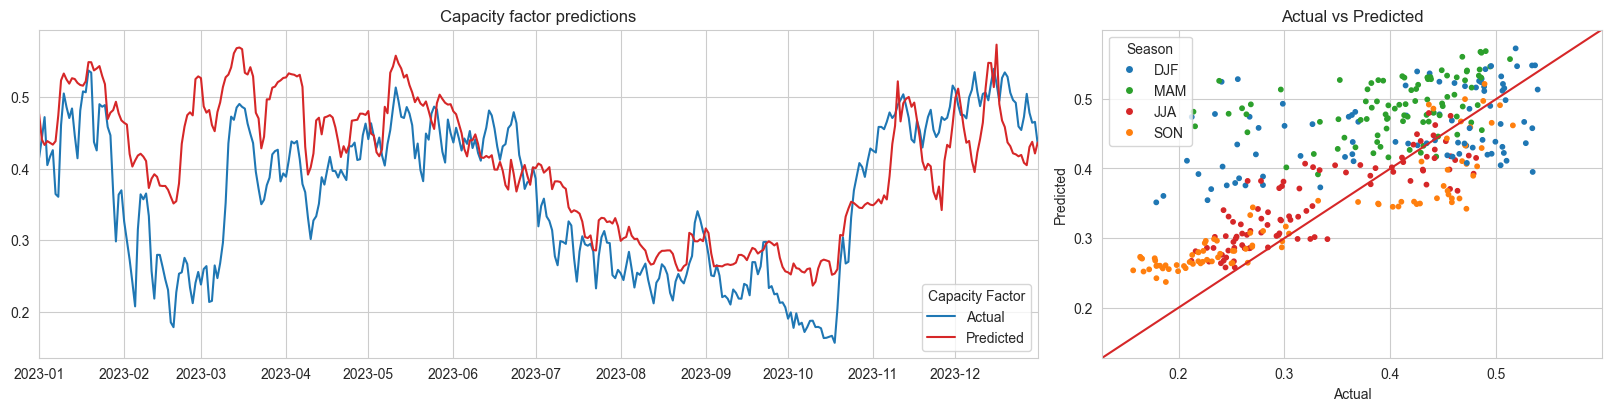

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

#données 

cf = pd.read_csv("data/CF_1d.csv", index_col = "Date", parse_dates = True)
ta = pd.read_csv("data/TA_1d.csv", index_col = "Date", parse_dates = True)
tp = pd.read_csv("data/TP_1d.csv", index_col = "Date", parse_dates = True)

cf_FR = cf[["FR"]]
ta_FR = ta[ta.columns[ta.columns.str.startswith("FR")]]
tp_FR = tp[tp.columns[tp.columns.str.startswith("FR")]]

# Features & Target
X = pd.merge(ta_FR.rolling(window=60, min_periods=1).mean(), tp_FR.rolling(window=7, min_periods=1).sum(), left_index = True, right_index = True, suffixes = ("_TA", "_TP"))
y = data["CF"]


# Séparation des données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=365, shuffle=False)

# Normalisation
scaler = StandardScaler().set_output(transform="pandas")
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#X_train_std["cos"] = np.cos(X_train_std.index.dayofyear * 2 * np.pi/365)
#X_train_std["sin"] = np.sin(X_train_std.index.dayofyear * 2 * np.pi/365)

#X_test_std["cos"] = np.cos(X_test_std.index.dayofyear * 2 * np.pi/365)
#X_test_std["sin"] = np.sin(X_test_std.index.dayofyear * 2 * np.pi/365)

results2 = {"Actual": y_test}

from sklearn.ensemble import RandomForestRegressor

# Modèle Random Forest
rf = RandomForestRegressor(
    n_estimators=300,   # nombre d'arbres
    max_depth= 10,    # profondeur illimitée
    random_state=30,
    n_jobs=-1          # utilise tous les cœurs CPU
)

# Entraînement
rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

# Ajout dans results
results2["GBR"] = y_pred

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.06f}")
print(f"MSE: {mse:.06f}")
print()

display_result_season(y_test, y_pred)

Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


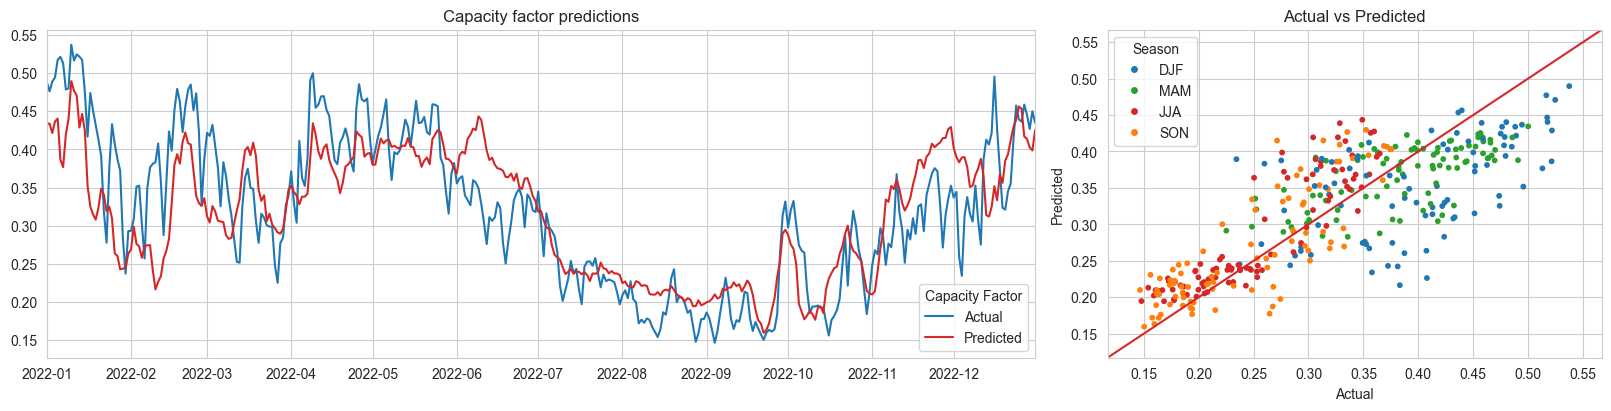

R2 : 0.6533412708833894
MSE : 0.003378240651999004
MAE : 0.04610558302164146
-0.07097510915462311
Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


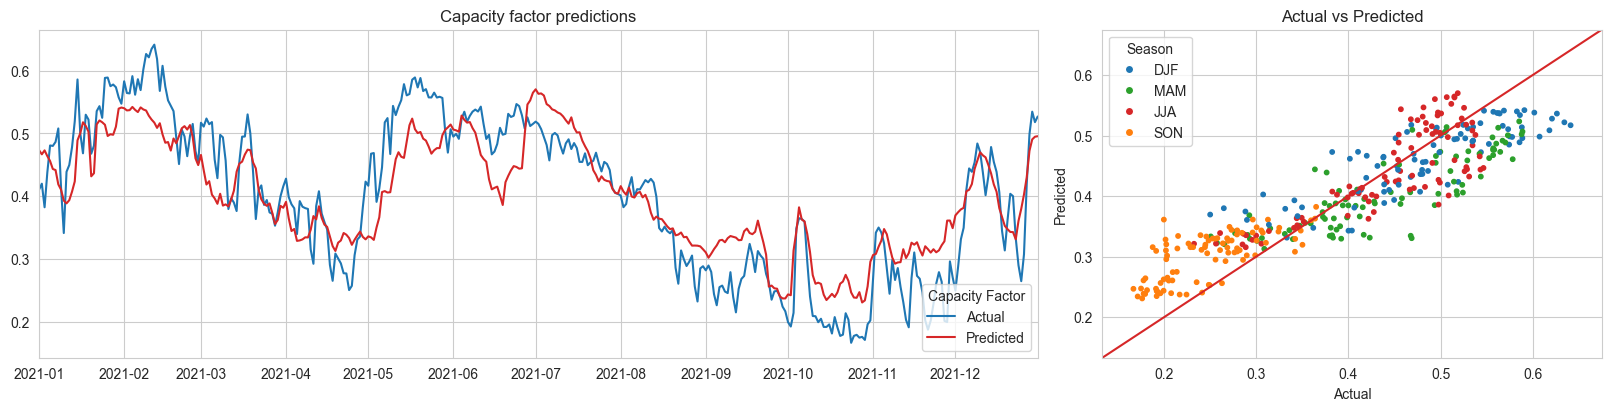

R2 : 0.7714780302072954
MSE : 0.0033455309855941412
MAE : 0.04753903743101642
-0.03221914735389949
Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


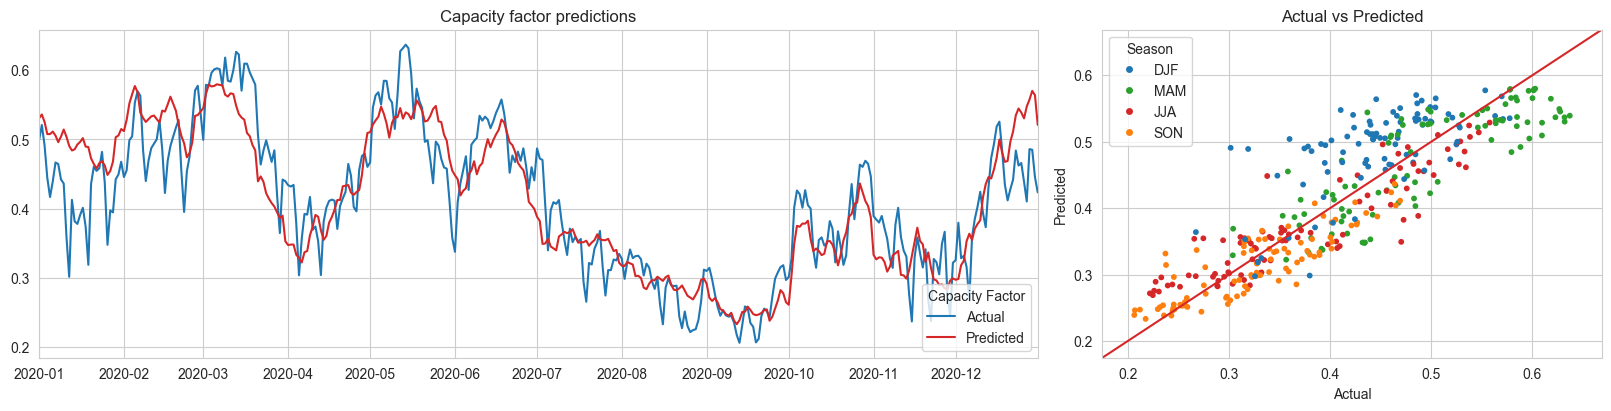

R2 : 0.7505045900427658
MSE : 0.0026049171558812016
MAE : 0.04075149123532122
0.0024760210050082964
Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


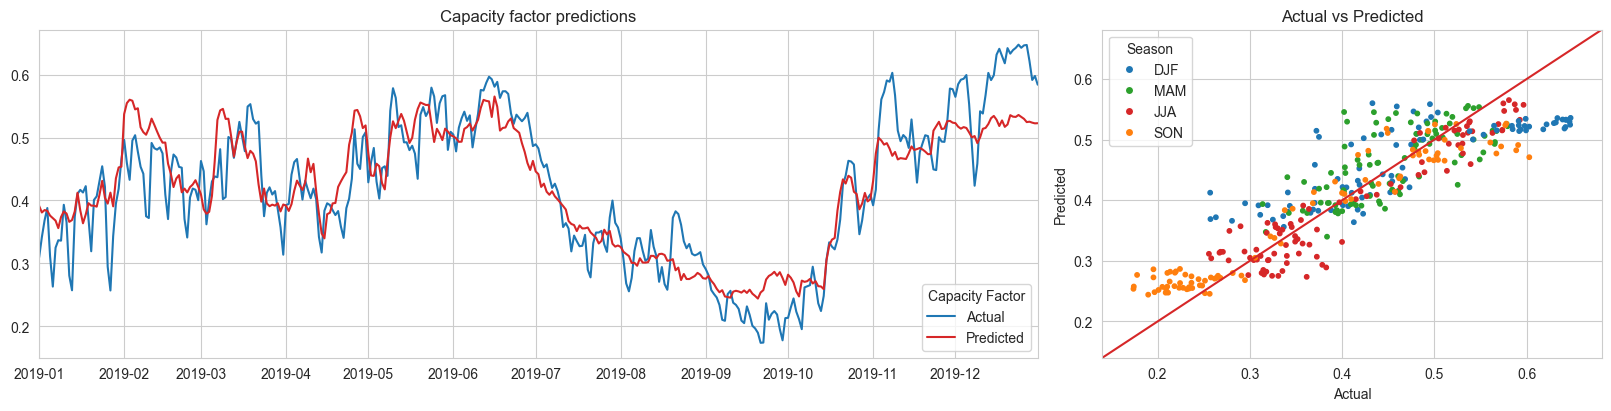

R2 : 0.7947855021130623
MSE : 0.002705488780201737
MAE : 0.0413965092386588
0.02386754257899439
Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


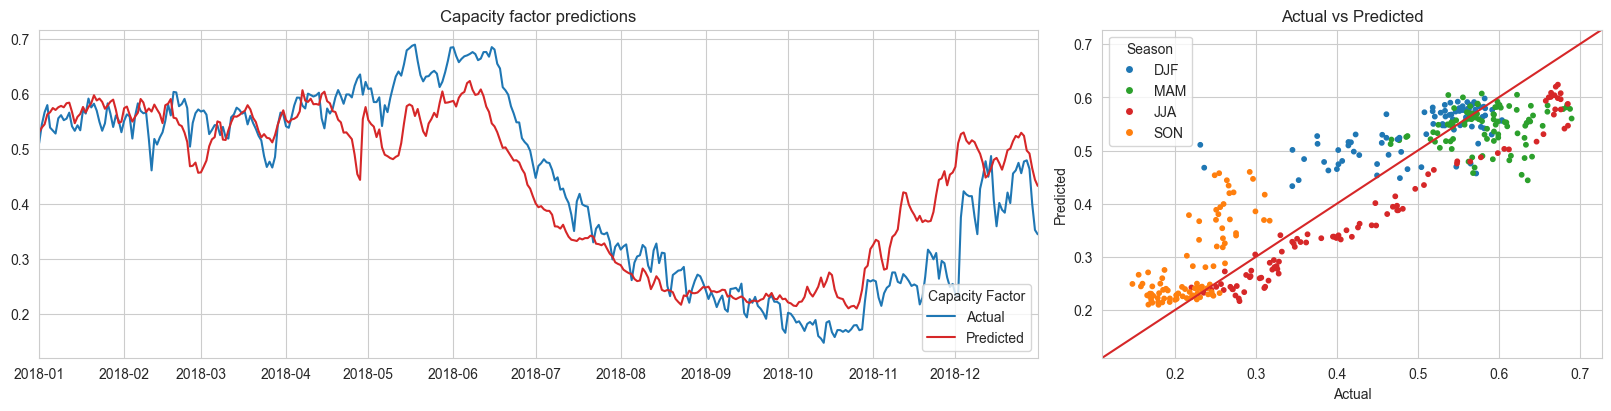

R2 : 0.8079169409159128
MSE : 0.0050507896865121344
MAE : 0.05562176367686404
0.009172801541130612
Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


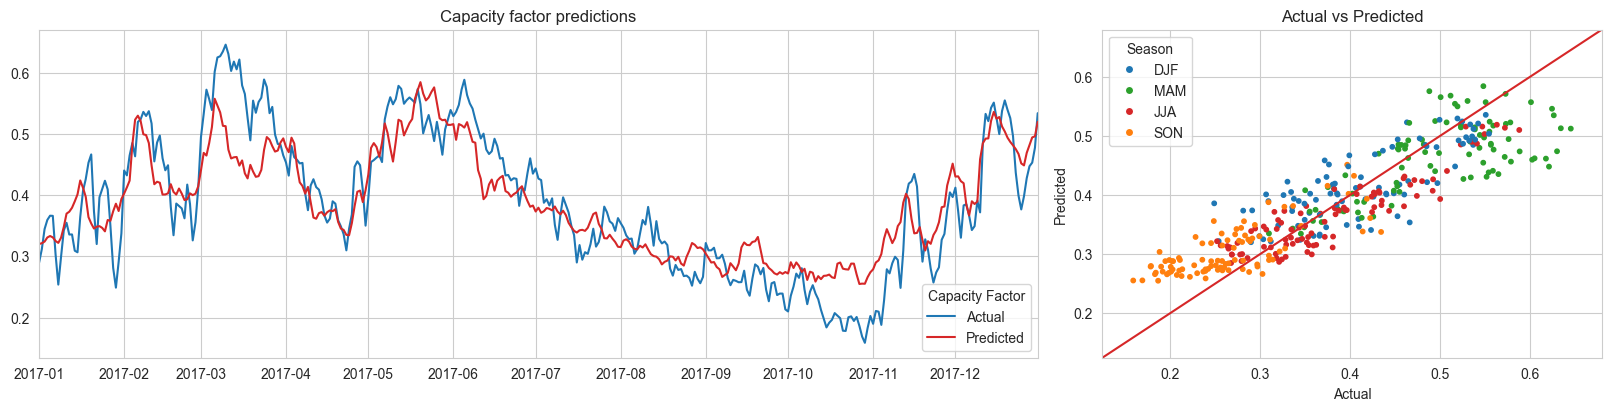

R2 : 0.767375880012706
MSE : 0.0029996246207110496
MAE : 0.04458892485875
0.028820604344202205
Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


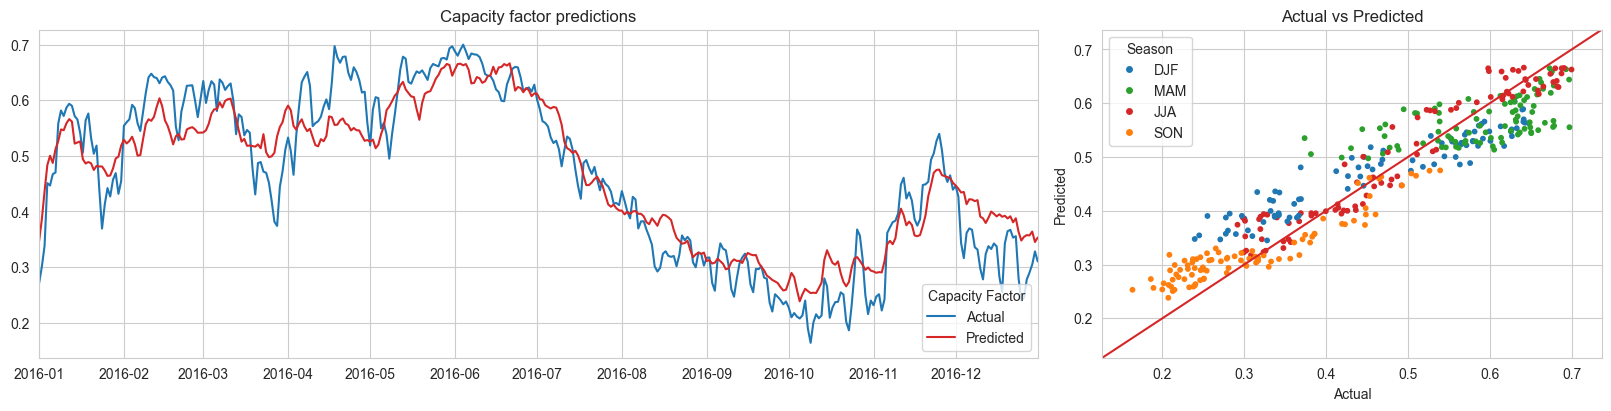

R2 : 0.8678951116320606
MSE : 0.002929848229517632
MAE : 0.04509352563212599
0.05100870678520545
Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


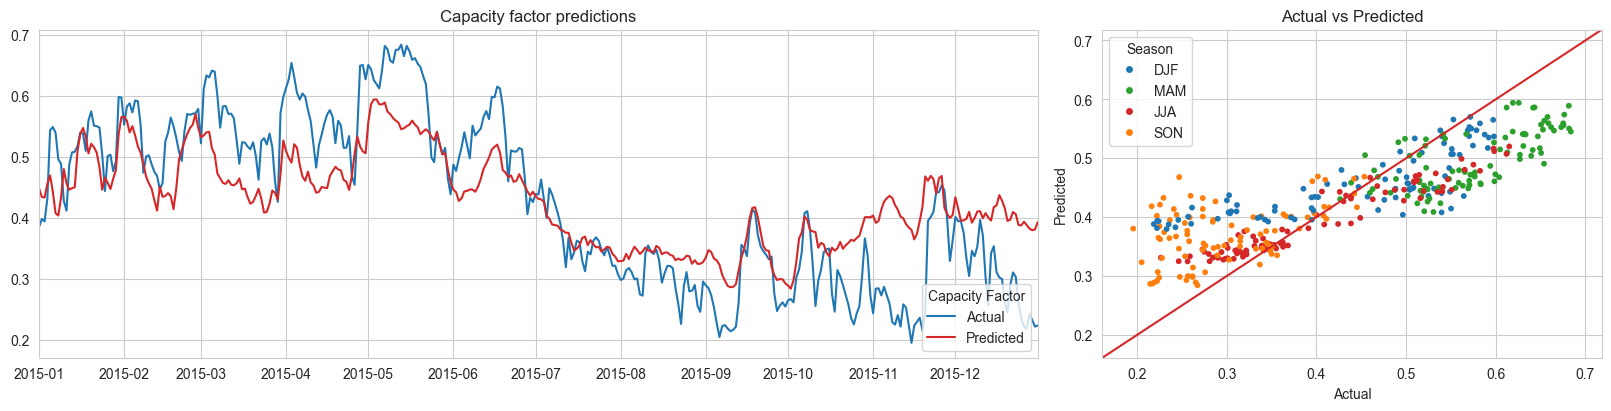

R2 : 0.6397622535505332
MSE : 0.006484971335729758
MAE : 0.06483970407067625
0.05610998546266103
0.008532675651084926


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

# --- 1. CHARGEMENT ET PRÉPARATION ---
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=True)
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=True)
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=True)

# Sélection FR uniquement
y = cf["FR"].rename("Target")
ta_fr = ta[ta.columns[ta.columns.str.startswith("FR")]].mean(axis=1).rename("TA")
tp_fr = tp[tp.columns[tp.columns.str.startswith("FR")]].mean(axis=1).rename("TP")

# Création d'un DataFrame unique pour le feature engineering
df = pd.concat([ta_fr, tp_fr, y], axis=1).dropna()



# Court terme (réaction rapide), Moyen terme (sols), Long terme (réservoirs/nappes)
for window in [7, 30, 90]:
    df[f'TP_roll_{window}'] = df['TP'].rolling(window=window).sum()
    df[f'TA_roll_{window}'] = df['TA'].rolling(window=window).mean()

# C. Effet "Retard" (Lags)
lags = [1, 2, 7, 14]
for lag in lags:
    df[f'TP_lag_{lag}'] = df['TP'].shift(lag)
    

# Séparation X et y
features = [c for c in df.columns if c != "Target"]
X = df[features]
y = df["Target"]


Bias = []

for i in range(2,10) : 

    # --- 3. SPLIT ET NORMALISATION ---
    # Split temporel strict (pas de shuffle)
    test_size = 365
    X_train, X_test = pd.concat([X.iloc[:-i*test_size],X.iloc[-(i-1)*test_size:] ]), X.iloc[-i*test_size: -(i-1)*test_size]
    y_train, y_test = pd.concat([y.iloc[:-i*test_size], y.iloc[-(i-1)*test_size:]]), y.iloc[-i*test_size: -(i-1)*test_size]
    
        
    # Normalisation 
    scaler = StandardScaler().set_output(transform="pandas")
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # --- 4. MODÉLISATION ET OPTIMISATION ---
    
    # Définition du modèle de base
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # Recherche d'hyperparamètres (Optimisation)
    
    param_dist = {
        'n_estimators': [200, 300, 400, 500, 600],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None] 
    }
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=10, # Augmente ce nombre si tu as du temps CPU (ex: 50)
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    print("Démarrage de l'entraînement")
    random_search.fit(X_train_scaled, y_train)
    
    best_model = random_search.best_estimator_
    print(f"Meilleurs paramètres : {random_search.best_params_}")
    
    # --- 5. ÉVALUATION ---
    y_pred = best_model.predict(X_test_scaled)
    
    bias = optimize_bias(y_test, y_pred)
    y_pred = y_pred + bias
    
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    
    display_result_season(y_test, y_pred)
    print(f"R2 : {r2}")
    print(f"MSE : {mse}")
    print(f"MAE : {mae}")
    print(bias)
    Bias.append(bias)


optimal_bias = np.mean(Bias)

print(optimal_bias)



In [84]:


def optimize_bias(y_test, y_pred):
    residuals = y_test - y_pred

    mean_error = residuals.mean()
    std_error = residuals.std()
    
    # On teste 1000 biais possibles entre (Moyenne - 2 Ecart-types) et (Moyenne + 2 Ecart-types)
    biases = np.linspace(mean_error - std_error, mean_error + std_error, 1000)
    
    results = []
    
    # 3. Boucle de calcul (Simulation)
    for b in biases:
        # On applique le biais temporaire
        y_pred_adjusted = y_pred + b
        
        # On calcule les métriques
        r2 = r2_score(y_test, y_pred_adjusted)
        mse = mean_squared_error(y_test, y_pred_adjusted)
        mae = mean_absolute_error(y_test, y_pred_adjusted)
        
        results.append({
            'bias': b,
            'r2': r2,
            'mse': mse,
            'mae': mae
        })
        
    df_results = pd.DataFrame(results)
    
    # 4. Trouver les optimums
    # Le meilleur R2 est le MAX
    best_bias_r2 = df_results.loc[df_results['r2'].idxmax()].bias
    # La meilleure MSE est le MIN
    best_bias_mse = df_results.loc[df_results['mse'].idxmin()].bias
    # La meilleure MAE est le MIN
    best_bias_mae = df_results.loc[df_results['mae'].idxmin()].bias
    
    avg_bias = (best_bias_r2 + best_bias_mse + best_bias_mae)/3
    return avg_bias

Démarrage de l'entraînement
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
0.008532675651084926


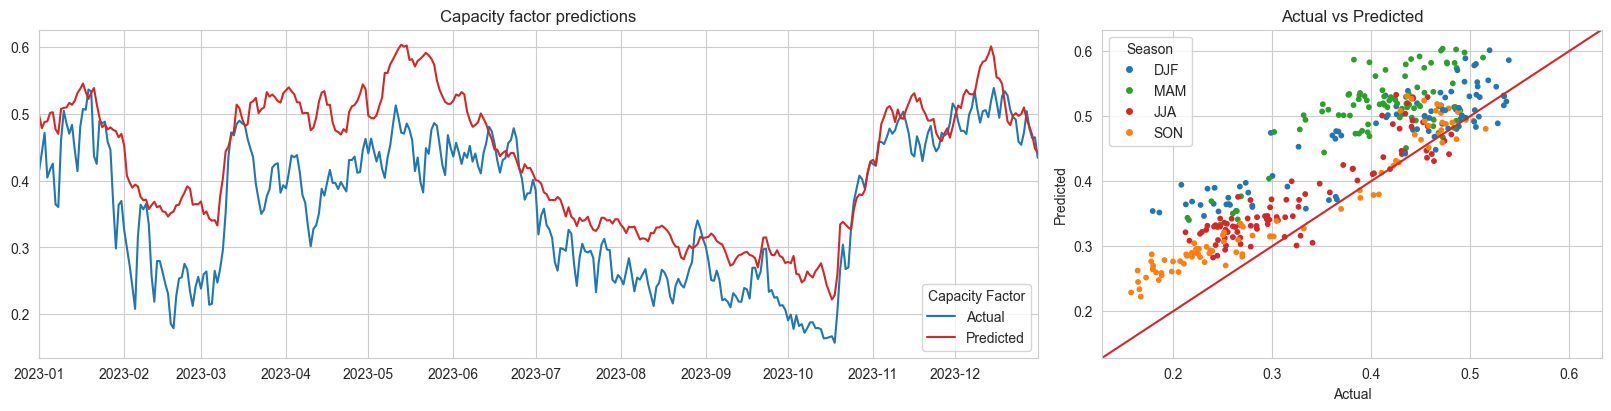

R2 : 0.4026587431240465
MSE : 0.006444515013813825
MAE : 0.06712562703969432


In [106]:
#Test final sur 2023 : 




# Split temporel strict (pas de shuffle)
test_size = 365
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
        
# Normalisation 
scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
# --- 4. MODÉLISATION ET OPTIMISATION ---
    
# Définition du modèle de base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
# Recherche d'hyperparamètres (Optimisation)
    
param_dist = {
        'n_estimators': [200, 300, 400, 500, 600],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None] 
    }
    
tscv = TimeSeriesSplit(n_splits=3)
    
random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=10, # Augmente ce nombre si tu as du temps CPU (ex: 50)
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
print("Démarrage de l'entraînement")
random_search.fit(X_train_scaled, y_train)
    
best_model = random_search.best_estimator_
print(f"Meilleurs paramètres : {random_search.best_params_}")
    
# --- 5. ÉVALUATION ---
y_pred = best_model.predict(X_test_scaled)
    
y_pred = y_pred + optimal_bias
print(optimal_bias)
    
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

    
display_result_season(y_test, y_pred)
print(f"R2 : {r2}")
print(f"MSE : {mse}")
print(f"MAE : {mae}")